# Анализ бизнес-показателей приложения Procrastinate Pro+

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Необходимо разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

# Введение

**Проект направлен** на анализ бизнес-показателей организации и оценку окупаемости рекламы.

**Цель исследования** - получить ответы на следующие вопросы:

* Откуда приходят пользователи и какими устройствами они пользуются;
* Сколько стоит привлечение пользователей из различных рекламных каналов;
* Сколько денег приносит каждый клиент;
* Когда расходы на привлечение клиента окупаются;
* Какие факторы мешают привлечению клиентов.

**Описание исходных данных:**

В нашем распоряжении три датасета. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:
* *User Id* — уникальный идентификатор пользователя;
* *Region* — страна пользователя;
* *Device* — тип устройства пользователя;
* *Channel* — идентификатор источника перехода;
* *Session Start* — дата и время начала сессии;
* *Session End* — дата и время окончания сессии.

Структура orders_info_short.csv:
* *User Id* — уникальный идентификатор пользователя;
* *Event Dt* — дата и время покупки;
* *Revenue* — сумма заказа.

Структура costs_info_short.csv:
* *dt* — дата проведения рекламной кампании;
* *Channel* — идентификатор рекламного источника;
* *costs* — расходы на эту кампанию.

**Исследование пройдет в 4 основных этапа:**

 * Обзор исходных данных;
 * Предобработка исходных данных;
 * Исследовательский анализ данных;
 * Подсчет затрат и оценка окупаемости рекламы.

# Содержание <a id="Содержание"></a>

1. [Обзор исходных данных](#Обзор-исходных-данных)
2. [Предобработка данных](#Предобработка-данных)
3. [Определение функций для расчёта и анализа LTV, ROI, удержания и конверсии](#Определение-функций)
4. [Исследовательский анализ данных](#Исследовательский-анализ)
    * [Составление профилей пользователей](#Составление-профилей)
    * [Распределение по странам](#Распределение-по-странам)
    * [Распределение по устройствам](#Распределение-по-устройствам)
    * [Распределение по источникам привлечения](#Распределение-по-источникам)
5. [Вычисление расходов на маркетинг](#Расходы-на-маркетинг)
    * [Общая сумма расходов на маркетинг](#Сумма-расходов-на-маркетинг)
    * [Распределение трат по рекламным источникам](#Распределение-трат-по-источникам)
    * [Динамика изменения расходов во времени](#Динамика-расходов)
    * [Вычисление CAC](#Вычисление-САС)
6. [Оценка окупаемости рекламы](#Оценка-окупаемости-рекламы)
    * [Анализ окупаемости рекламы c помощью графиков LTV и ROI и графиков динамики LTV, CAC и ROI](#Анализ-окупаемости)
    * [Проверка конверсии пользователей и удержания](#Конверсия-и-удержание)
    * [Анализ окупаемости рекламы с разбивкой по устройствам](#Окупаемость-по-устройствам)
    * [Анализ окупаемости рекламы с разбивкой по странам](#Окупаемость-по-странам)
    * [Анализ окупаемости рекламы с разбивкой по рекламным каналам](#Окупаемость-по-каналам)
    * [Ответ на поставленные в исследовании вопросы](#Ответ-на-вопросы)
7. [Общий вывод](#Общий-вывод)

<a id='Обзор-исходных-данных'></a>
## Обзор исходных данных

In [1]:
#импортируем необходимые для проекта библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns

In [2]:
#сохраним датасеты в дф
visits, orders, costs = (pd.read_csv('/datasets/visits_info_short.csv'),
                         pd.read_csv('/datasets/orders_info_short.csv'),
                         pd.read_csv('/datasets/costs_info_short.csv'))

Проверим предложенные данные:

In [3]:
#поскольку у нас 3 дф определим функцию для оптимизации
#(откажемся от цикла, чтобы была возможность текстово описать каждый отдельный результат вывода)
def data_info(data):
    '''
    Аргумент функции - название датасета.
    Функция выводит первые 5 строк датасета, информацию по нему и гистограммы по числовым столбцам.
    '''
    display(data.head())
    data.info()
    data.hist(figsize=(15, 5))
    plt.show()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


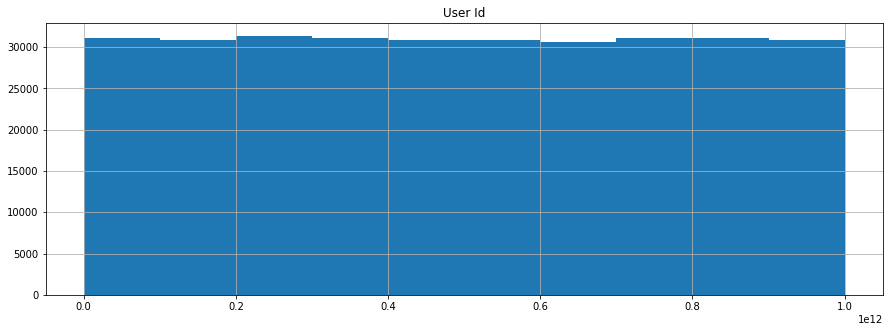

In [4]:
data_info(visits)

Пропусков нет. Видим, что для удобной работы с датафреймом необходимо будет исправить названия столбцов - убрать пробелы, использовать только нижний регистр. Также необходимо изменить тип данных в столбцах Session Start и Session End на datetime.

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


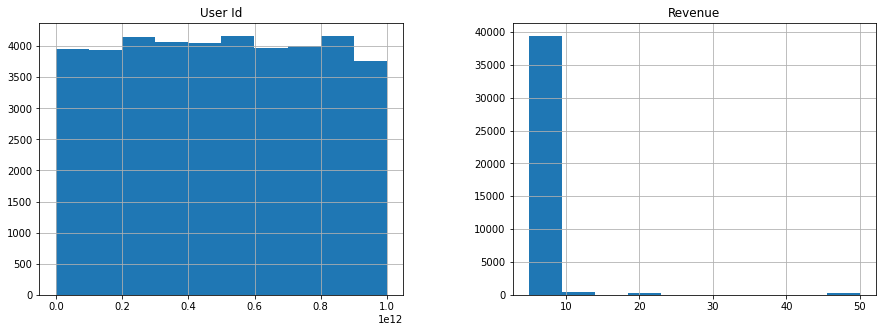

In [5]:
data_info(orders)

Аналогично датафрейму Visits: пропусков нет, необходимо будет исправить названия столбцов и изменить тип данных в столбце Event Dt на datetime. Также замечены аномальные значения в столбце с выручкой около 20 и 50. 

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


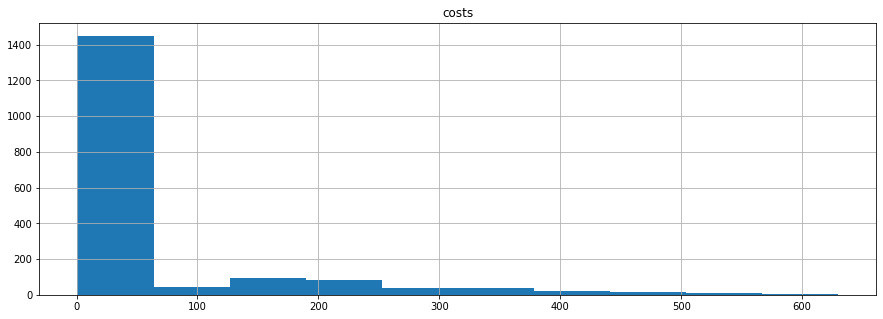

In [6]:
data_info(costs)

Пропусков нет, типы данных в порядке. Исправим название столбца Channel. Также нужно отметить, что гистограмма расходов на рекламную кампанию имеет, предварительно, нехарактерный хвост вправо с резким падением около 70. 

**Вывод:**

Мы провели первичный обзор данных, не было выявлено пропусков, необходимо изменить тип данных в столбцах с датами и исправить наименования столбцов.

[Вернуться к содержанию](#Содержание)

<a id="Предобработка-данных"></a>
## Предобработка данных

Сначала решим проблему с наименованиями столбцов:

In [7]:
#воспользуемся циклами для оптимизации
for i in [visits, orders, costs]:
    i.columns = (j.lower().replace(' ', '_') for j in i.columns)

Изменим тип данных в столбцах с датами:

In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Проверим изменения:

In [9]:
for i in [visits, orders, costs]:
    display(i.head(3))
    print(i.info())
    print()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
None



,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB
None



,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None



Названия и тип данных корректны. 

Проверим наши данные на наличие дубликатов. Начнем с явных:

In [10]:
data_list = {'visits':visits, 'orders':orders, 'costs':costs}

for name, df in data_list.items():
    print(f'Количество дубликатов в {name}:', df.duplicated().sum())
    df = df.drop_duplicates() 
    if name == 'visits':
        visits = df
    elif name == 'orders':
        orders = df
    elif name == 'costs':
        costs = df
    print(f'Количество дубликатов в {name} после обработки:', df.duplicated().sum())
    print()

Количество дубликатов в visits: 0
Количество дубликатов в visits после обработки: 0

Количество дубликатов в orders: 0
Количество дубликатов в orders после обработки: 0

Количество дубликатов в costs: 0
Количество дубликатов в costs после обработки: 0



Явных дубликатов не выявлено, поищем неявные - они могут быть в датафрейме с посещениями в столбцах *region*, *device*, *channel* и в аналогичном столбце с каналами в датафрейме со стоимостью рекламных кампаний:

In [11]:
#проверим уникальные значения в обозначенных столбцах
for i in [visits['region'], visits['device'], visits['channel'], costs['channel']]:
    print(f'Количество уникальных значений {i.name}:', i.nunique())
    print(i.sort_values().unique())
    print()

Количество уникальных значений region: 4
['France' 'Germany' 'UK' 'United States']

Количество уникальных значений device: 4
['Android' 'Mac' 'PC' 'iPhone']

Количество уникальных значений channel: 11
['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreativeMedia'
 'RocketSuperAds' 'TipTop' 'WahooNetBanner' 'YRabbit' 'lambdaMediaAds'
 'organic']

Количество уникальных значений channel: 10
['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreativeMedia'
 'RocketSuperAds' 'TipTop' 'WahooNetBanner' 'YRabbit' 'lambdaMediaAds']



Неявных дубликатов не выявлено.

**Вывод:**

Мы провели предобработку данных:

* Названия столбцов и типы их данных приведены стандарту;
* Дубликаты в датафреймах не выявлены.

[Вернуться к содержанию](#Содержание)

<a id="Определение-функций"></a>
## Определение функций для расчёта и анализа LTV, ROI, удержания и конверсии

Для удобства в расчетах зададим функции для вычисления значений метрик:

Функция для создания профилей пользователей:

In [12]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Функция для подсчёта Retention Rate:

In [13]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для подсчета конверсии:

In [14]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для подсчета LTV:

In [15]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Зададим функции для построения графиков: 

Функция для сглаживания данных:

In [16]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

Функция для построения графика Retention Rate:

In [17]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

Функция для построения графика конверсии:

In [18]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функция для визуализации LTV и ROI:

In [19]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Вывод:**

Были заданы функции:

* *get_profiles()* — для создания профилей пользователей,
* *get_retention()* — для подсчёта Retention Rate,
* *get_conversion()* — для подсчёта конверсии,
* *get_ltv()* — для подсчёта LTV,
* *filter_data()* — для сглаживания данных,
* *plot_retention()* — для построения графика Retention Rate,
* *plot_conversion()* — для построения графика конверсии,
* *plot_ltv_roi* — для визуализации LTV и ROI.

[Вернуться к содержанию](#Содержание)

<a id='Исследовательский-анализ'></a>
## Исследовательский анализ данных

<a id='Составление-профилей'></a>
Составим профили пользователей:

In [20]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Выясним минимальную и максимальную дату привлечения в наших данных:

In [21]:
f'Минимальная дата привлечения: {profiles["first_ts"].min()}, максимальная дата привлечения: {profiles["first_ts"].max()}'

'Минимальная дата привлечения: 2019-05-01 00:00:41, максимальная дата привлечения: 2019-10-27 23:59:04'

Даты соответствуют нашим границам привлечения в данных: с 1 мая по 27 октября 2019 года.

<a id='Распределение-по-странам'></a>
Вычислим, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей:

При предобработке данных, а именно - устранении дубликатов, мы видели, что все страны в нашем датасете приходятся на США, Францию, Германию и Англию. Разберемся с распределением пользователей по этим странам:

In [22]:
#сформируем таблицу
region_profiles = profiles.groupby('region')['user_id'].nunique().reset_index()
region_profiles['payers_count'] = region_profiles['region'].map(
                                  profiles[profiles['payer'] == True].groupby('region')['user_id'].nunique())
region_profiles['payers_part'] = region_profiles['payers_count'] / region_profiles['user_id']
region_profiles

,region,user_id,payers_count,payers_part
0,France,17450,663,0.037994
1,Germany,14981,616,0.041119
2,UK,17575,700,0.039829
3,United States,100002,6902,0.069019


Представим данные визуально:

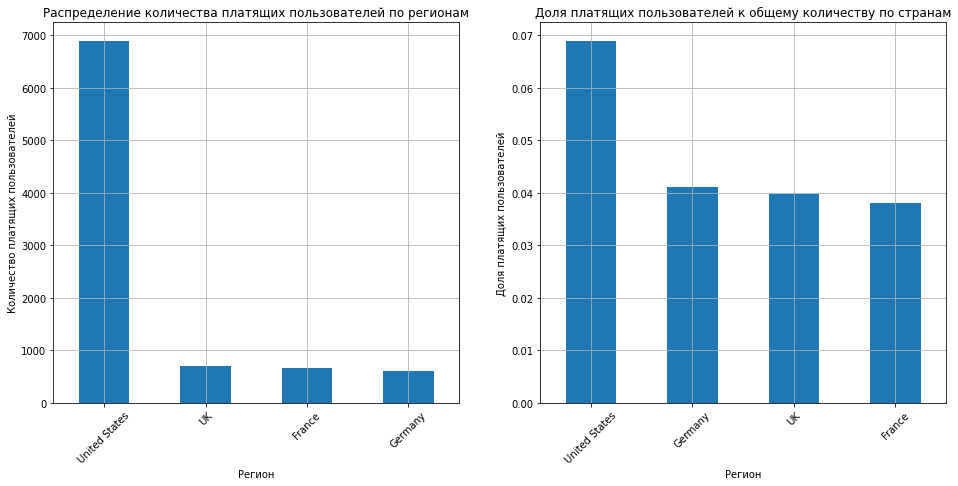

In [23]:
#построим 2 графика с интересующими нас значениями

plt.figure(figsize=(16,7))

plt.subplot(1, 2, 1)
region_profiles.sort_values(by='payers_count', ascending=False).set_index('region')['payers_count'].plot(kind='bar', grid=True)
plt.xlabel('Регион')
plt.ylabel('Количество платящих пользователей')
plt.title('Распределение количества платящих пользователей по регионам')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
region_profiles.sort_values(by='payers_part', ascending=False).set_index('region')['payers_part'].plot(kind='bar', grid=True)
plt.xlabel('Регион')
plt.ylabel('Доля платящих пользователей')
plt.title('Доля платящих пользователей к общему количеству по странам')
plt.xticks(rotation=45)
plt.show()

Видим, что как количество платящих пользователей, так и наивысшая доля платящих пользователей приходятся на США: 7000 пользователей и почти 7% платящих среди обещго количества, соответственно. 

<a id='Распределение-по-устройствам'></a>
Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи:

При предобработке мы вяснили все устройства из наших данных - это Android, Mac, PC, iPhone. Определим, какими устройствами пользуются клиенты сервиса:

In [24]:
#сформируем таблицу
device_profiles = profiles.groupby('device')['user_id'].nunique().reset_index()
device_profiles['payers_count'] = device_profiles['device'].map(
                                  profiles[profiles['payer'] == True].groupby('device')['user_id'].nunique())
device_profiles['payers_part'] = device_profiles['payers_count'] / device_profiles['user_id']
device_profiles

,device,user_id,payers_count,payers_part
0,Android,35032,2050,0.058518
1,Mac,30042,1912,0.063644
2,PC,30455,1537,0.050468
3,iPhone,54479,3382,0.062079


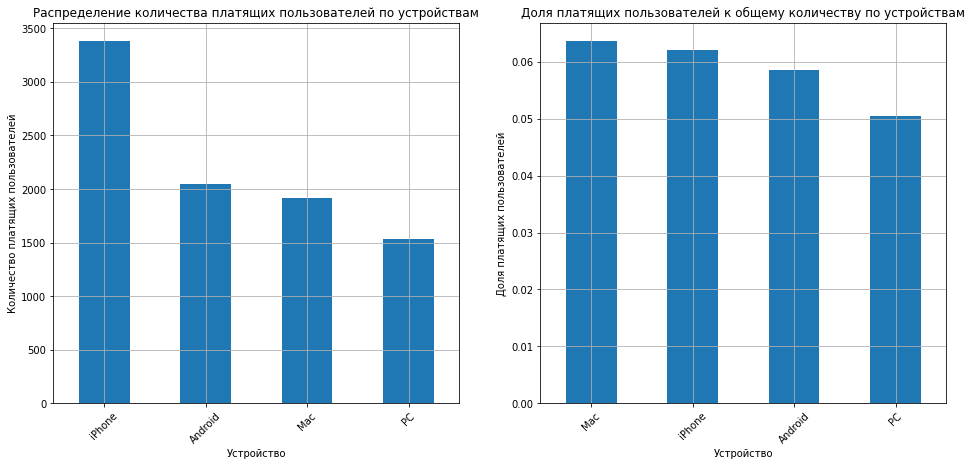

In [25]:
#построим 2 графика с интересующими нас значениями

plt.figure(figsize=(16,7))

plt.subplot(1, 2, 1)
device_profiles.sort_values(by='payers_count', ascending=False).set_index('device')['payers_count'].plot(kind='bar', grid=True)
plt.xlabel('Устройство')
plt.ylabel('Количество платящих пользователей')
plt.title('Распределение количества платящих пользователей по устройствам')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
device_profiles.sort_values(by='payers_part', ascending=False).set_index('device')['payers_part'].plot(kind='bar', grid=True)
plt.xlabel('Устройство')
plt.ylabel('Доля платящих пользователей')
plt.title('Доля платящих пользователей к общему количеству по устройствам')
plt.xticks(rotation=45)
plt.show()

Наибольшее количество платящих клиентов пользуются iPhone - около 3400 пользователей, однако лучшая конвертация у пользователей Mac - 6,3%, что не далеко от того же iPhone - 6,2%.

<a id='Распределение-по-источникам'></a>
Аналогично рассмотрим каналы привлечения:

Ранее мы выявили все каналы привлечения, которые присутствуют в наших данных: AdNonSense, FaceBoom, LeapBob, MediaTornado, OppleCreativeMedia, RocketSuperAds, TipTop, WahooNetBanner, YRabbit, lambdaMediaAds, organic - посмотрим, как обстоят дела с платящими пользователями, привлеченными по этим каналам. 

In [26]:
#сформируем таблицу
channel_profiles = profiles.groupby('channel')['user_id'].nunique().reset_index()
channel_profiles['payers_count'] = channel_profiles['channel'].map(
                                  profiles[profiles['payer'] == True].groupby('channel')['user_id'].nunique())
channel_profiles['payers_part'] = channel_profiles['payers_count'] / channel_profiles['user_id']
channel_profiles

,channel,user_id,payers_count,payers_part
0,AdNonSense,3880,440,0.113402
1,FaceBoom,29144,3557,0.122049
2,LeapBob,8553,262,0.030633
3,MediaTornado,4364,156,0.035747
4,OppleCreativeMedia,8605,233,0.027077
5,RocketSuperAds,4448,352,0.079137
6,TipTop,19561,1878,0.096007
7,WahooNetBanner,8553,453,0.052964
8,YRabbit,4312,165,0.038265
9,lambdaMediaAds,2149,225,0.104700


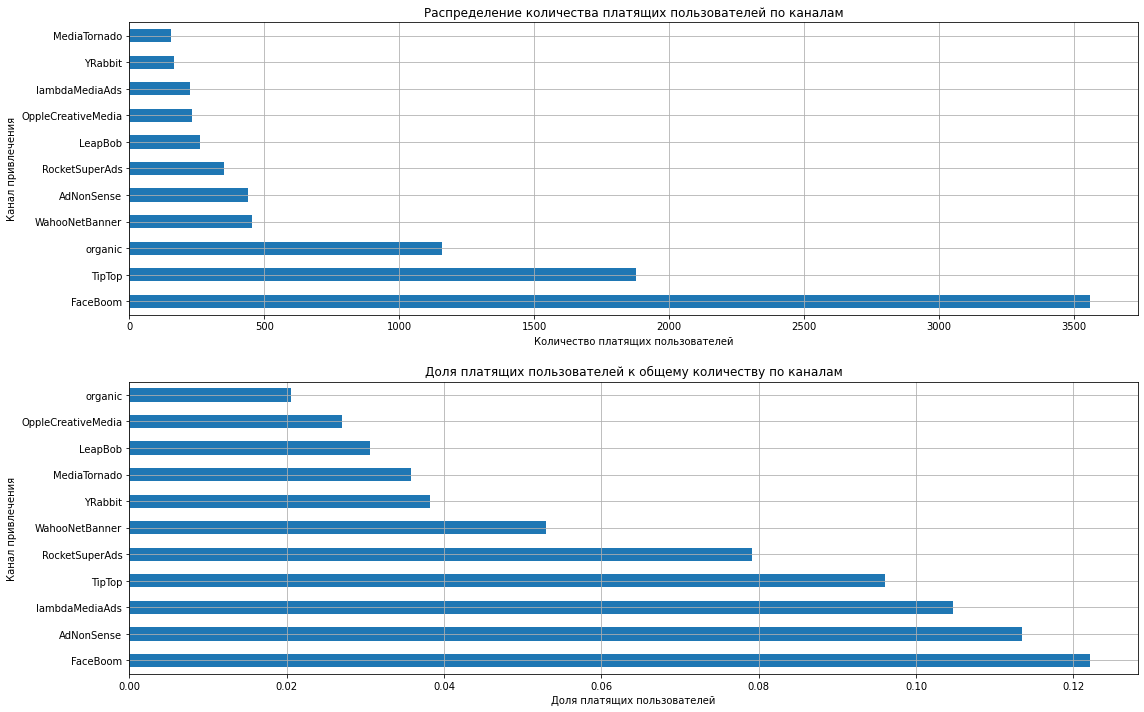

In [27]:
#построим 2 графика с интересующими нас значениями

plt.figure(figsize=(16,10))

plt.subplot(2, 1, 1)
channel_profiles.sort_values(by='payers_count', ascending=False).set_index('channel')['payers_count'].plot(kind='barh', 
                                                                                                             grid=True)
plt.xlabel('Количество платящих пользователей')
plt.ylabel('Канал привлечения')
plt.title('Распределение количества платящих пользователей по каналам')

plt.subplot(2, 1, 2)
channel_profiles.sort_values(by='payers_part', ascending=False).set_index('channel')['payers_part'].plot(kind='barh', 
                                                                                                           grid=True)
plt.xlabel('Доля платящих пользователей')
plt.ylabel('Канал привлечения')
plt.title('Доля платящих пользователей к общему количеству по каналам')

plt.tight_layout(h_pad=2)
plt.show()

Самым эффективным каналом в плане конвертации является FaceBoom, у которого наибольшее число платящих пользователей - около 3500, и наивысший коэффициент платящих пользователей - чуть выше 12%. 
Низший подобный коэффициент у канала 'organic' - органично привлеченные пользователи реже становятся платящими клиентами, однако по этому каналу приложение получило около 1100 бесплатных платящих клиентов. 

**Вывод:**

* США является лидером среди всех стран по количеству пользователей и конвертации в платных пользователей. Около 7% пользователей из США совершают покупки. Страны Европы значительно уступают по этим показателям. 

* По устройствам явного лидера выявить сложнее: iPhone превосходит другие устройства по общему количеству платящих пользователей - 3382, по конвертации на первом месте Mac с 6,4%, однако, iPhone по этому показателю на втором месте с 6,2%.

* Самое большое количество платящих пользователей было привлечено через FaceBoom — 3557 пользователей, это 12.2% платящих из общего числа привлеченных по этому каналу, это лучшие показатели среди неорганических каналов.

[Вернуться к содержанию](#Содержание)

<a id='Расходы-на-маркетинг'></a>
## Вычисление расходов на маркетинг

<a id='Сумма-расходов-на-маркетинг'></a>
Посчитаем общую сумму расходов на маркетинг:

In [28]:
costs['costs'].sum()

105497.30000000002

Это бюджет, выделенный на оплату услуг по привлечению пользователей, за выбранный нами период. 

<a id='Распределение-трат-по-источникам'></a>
Посмотрим, как эта сумма распределяется между каналами привлечения:

In [29]:
#создадим таблицу трат на каждый канал
channel_costs = costs.groupby('channel')['costs'].sum().sort_values(ascending=False).reset_index()
channel_costs['cost_part'] = channel_costs['costs'] / channel_costs['costs'].sum()
channel_costs

,channel,costs,cost_part
0,TipTop,54751.30,0.518983
1,FaceBoom,32445.60,0.307549
2,WahooNetBanner,5151.00,0.048826
3,AdNonSense,3911.25,0.037074
4,OppleCreativeMedia,2151.25,0.020392
5,RocketSuperAds,1833.00,0.017375
6,LeapBob,1797.60,0.017039
7,lambdaMediaAds,1557.60,0.014764
8,MediaTornado,954.48,0.009047
9,YRabbit,944.22,0.008950


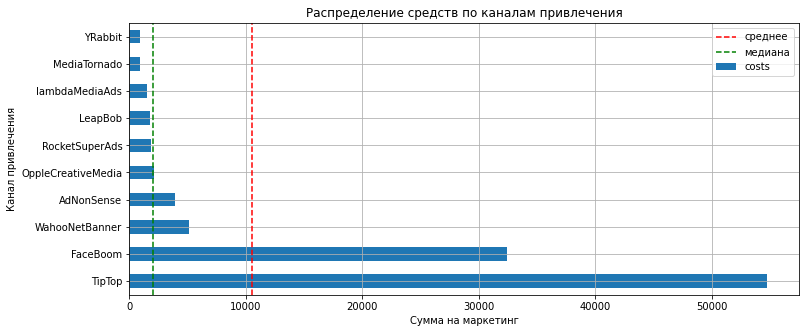

In [30]:
#сформируем график для наглядности
channel_costs.set_index('channel')['costs'].plot(kind='barh', grid=True, figsize=(12,5))
plt.axvline(channel_costs['costs'].mean(), color='red', linestyle='--', label='среднее')
plt.axvline(channel_costs['costs'].median(), color='g', linestyle='--', label='медиана')
plt.xlabel('Сумма на маркетинг')
plt.ylabel('Канал привлечения')
plt.title('Распределение средств по каналам привлечения')
plt.legend()
plt.show()

Очевидно, что каналы FaceBoom и TipTop сильно превзошли остальных по затраченным на них средствам: 80% от общего пула (50% и 30% соответственно).

<a id='Динамика-расходов'></a>
Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику:

In [31]:
#сначала сформируем таблицу - добавим столбцы с месяцем и неделей
#для этого вернем столбцу dt в costs тип datetime (сейчас там datetime.date)
dt_costs = costs
dt_costs['dt'] = pd.to_datetime(dt_costs['dt'])
dt_costs['month'] = dt_costs['dt'].dt.month
dt_costs['week'] = dt_costs['dt'].dt.isocalendar().week
dt_costs.sample(5)

,dt,channel,costs,month,week
1033,2019-09-11,AdNonSense,9.450,9,37
1541,2019-08-10,WahooNetBanner,43.200,8,32
1577,2019-09-15,WahooNetBanner,38.400,9,37
493,2019-09-11,RocketSuperAds,4.225,9,37
1714,2019-08-03,lambdaMediaAds,8.000,8,31


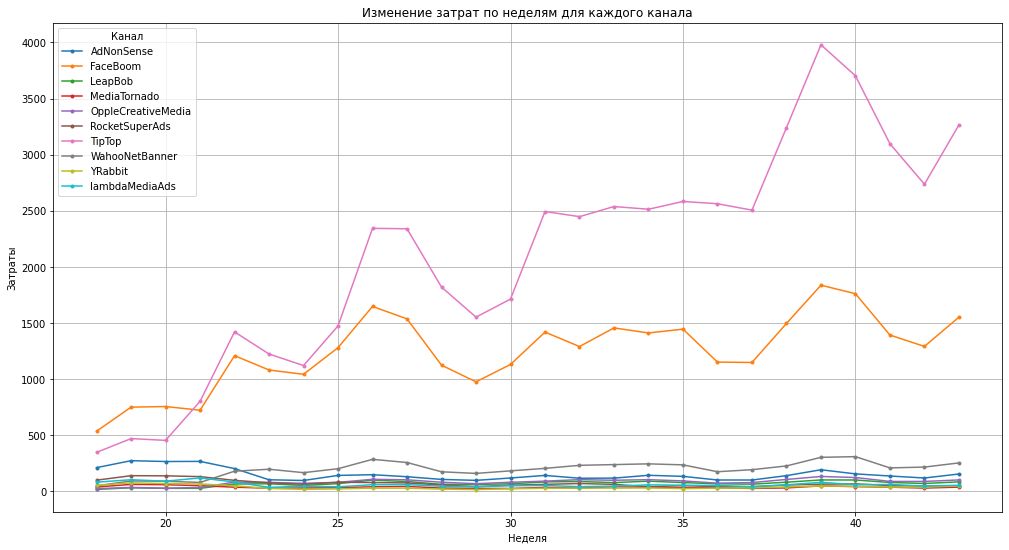

In [32]:
#создадим датафреймы для графиков с группировкой по месяцам и неделям отдельно
month_channel_costs = dt_costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
week_channel_costs = dt_costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
#перейдем к построению графика
week_channel_costs.plot(grid=True, figsize=(17,9), marker='.')
plt.xlabel('Неделя')
plt.ylabel('Затраты')
plt.title('Изменение затрат по неделям для каждого канала')
plt.legend(title='Канал')
plt.show()

Значительной динамики изменений затрат по каналам нет, все каналы идут практически всегда стабильно относительно их места в рейтинге общих затрат, за исключением первых 2 каналов, которые демонстрируют наибольшие колебания. Отметим, что до 21 недели затраты FaceBoom превышали TipTop, а AdNonSense - WahooNetBanner. 

Посмотрим по месяцам:

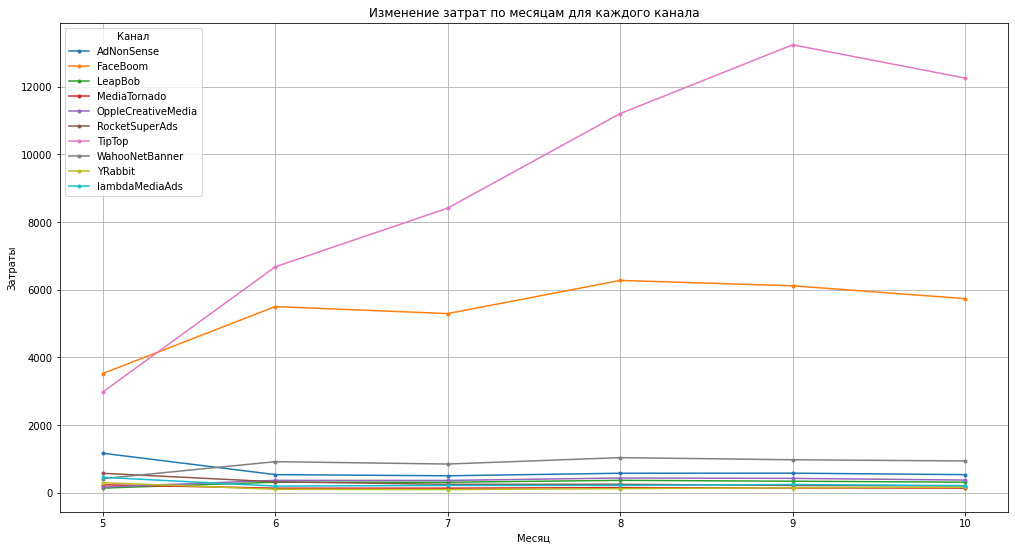

In [33]:
month_channel_costs.plot(grid=True, figsize=(17,9), marker='.')
plt.xlabel('Месяц')
plt.ylabel('Затраты')
plt.title('Изменение затрат по месяцам для каждого канала')
plt.legend(title='Канал')
plt.show()

Сгладился шум, по самой динамике ситуация аналогична графику по неделям. 

<a id='Вычисление-САС'></a>
Вычислим CAC по каждому источнику:

In [34]:
#составим таблицу с использованием profiles, где есть столбец со стоимостью привлечения пользователя
cac_by_channel = profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)
cac_by_channel

channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
organic               0.000000
Name: acquisition_cost, dtype: float64

Видим наибольшую стоимость привлечения 1 пользователя у TipTop, что выглядит невыгодно для нашей организации, если учитывать, что большое количество платящих пользователей в основном приходит к нам по каналу FaceBoom, который обходится дешевле почти в 2,5 раза. 

**Вывод:**

* Общая сумма расходов на меркетинг за период с 1 мая по 27 октября 2019 года составила 105497.3;
* В основном, средства на маркетинг расходуются на привлечение пользователей по каналам TipTop и FaceBoom (82%), на WahooNetBanner и AdNonSense тратится среднее количество средств относительно всех каналов (8,5%), на остальные - меньше медианы;
* За взятый период только TipTop и FaceBoom показывают динамику изменений, остальный каналы идут в основном ровно;
* Самый дорогой канал для привлечения - TipTop (2,8 за нового пользователя), самый дешевый, не считая organic - LeapBob (0,2 за нового пользователя).

[Вернуться к содержанию](#Содержание)

<a id='Оценка-окупаемости-рекламы'></a>
## Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы.

Установим момент и горизонт анализа данных. Сегодня 1 ноября 2019 года, зададим недельный горизонт анализа в 2 недели - так как в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения:

In [35]:
#момент анализа
observation_date = datetime(2019, 11, 1).date()
#горизонт анализа
horizon_days = 14

В дальнейшем при расчете окупаемости рекламы мы не будем включать пользователей, привлеченных "органически", так как они были привлечены без расходования средств из бюджета на маркетинг: 

In [36]:
paid_profiles = profiles[profiles['channel'] != 'organic']

<a id='Анализ-окупаемости'></a>
Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI:

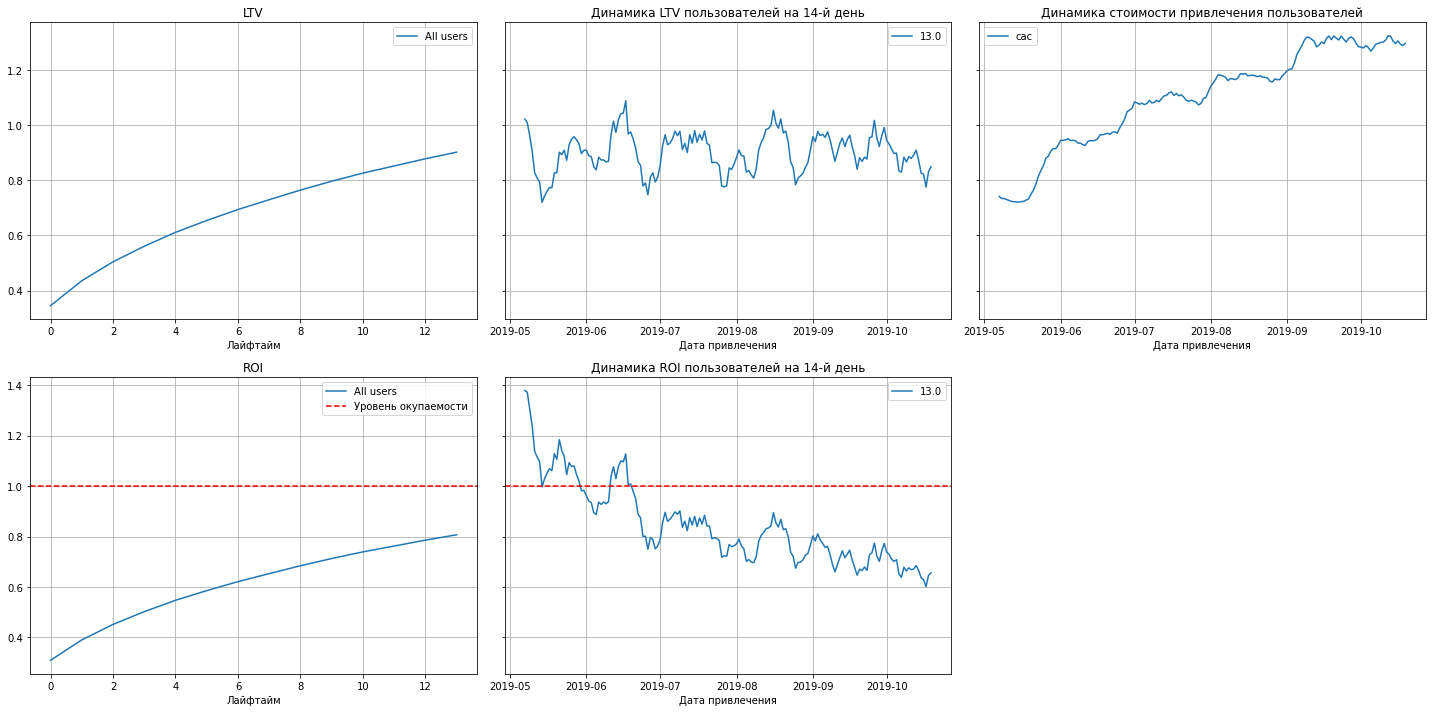

In [37]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(paid_profiles, orders, observation_date, horizon_days)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Видим, что с динамикой LTV все в порядке, однако проблемы возникают с показателями CAC и ROI: цена привлечения постоянно растет за весь взятый нами период, а ROI за 2 недельный лайфтайм в связи с этим падает - средства затраченные на привлечение пользователей не окупаются. 

<a id='Конверсия-и-удержание'></a>
Проверим конверсию и удержание пользователей, динамику их изменения:

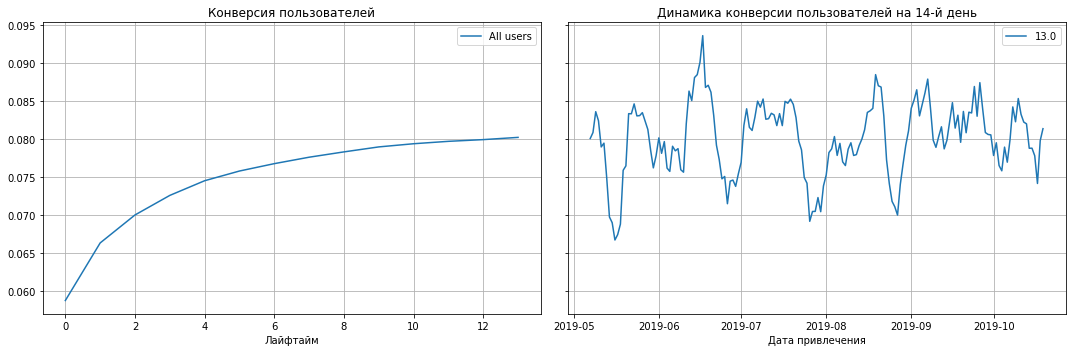

In [38]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    paid_profiles, orders, observation_date, horizon_days)
retention_raw, retention_grouped, retention_history = get_retention(
    paid_profiles, visits, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

В конверсии за 2х недельный лайфтайм нет ничего необычного. Можно отметить просадки в конвертации пользователей на 14 день у пользователей, привлеченных в мае - на текущем этапе сложно сказать, что случилось, без комментариев маркетологов и материалов по майским мероприятиям. 

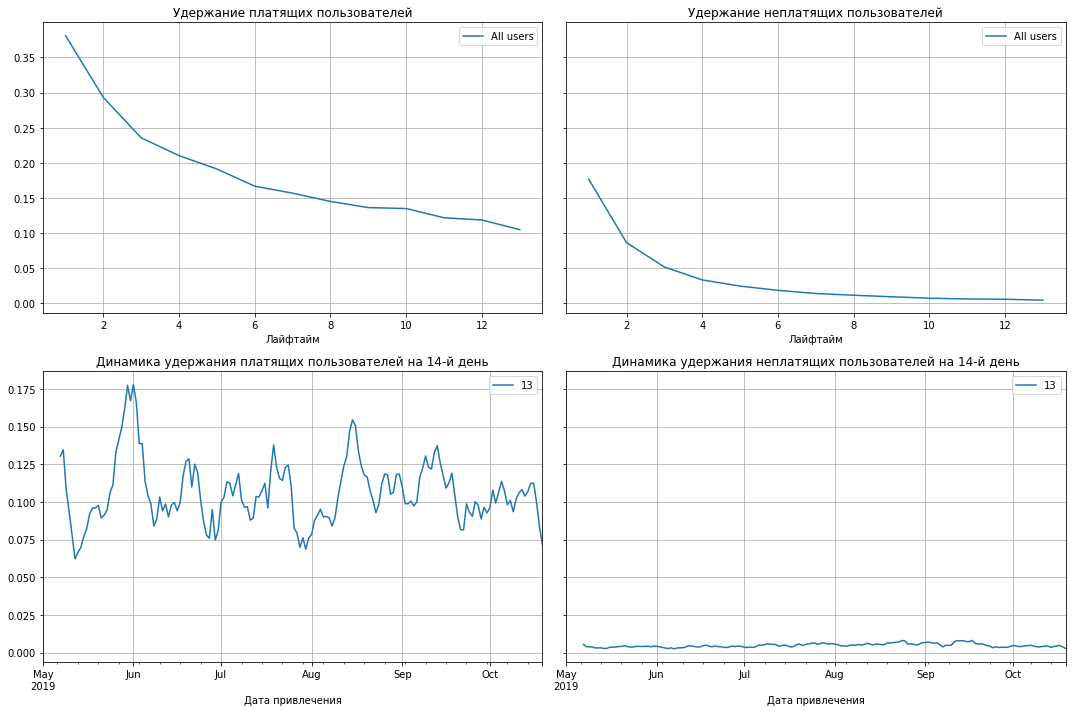

In [39]:
plot_retention(retention_grouped, retention_history, horizon_days) 

По графикам удержания не видим ничего необычного: платящие пользователи удерживаются лучше, чем неплатящие, динамика по датам привлечения аналогична конверсии.

<a id='Окупаемость-по-устройствам'></a>
Проанализируем окупаемость рекламы с разбивкой по устройствам:

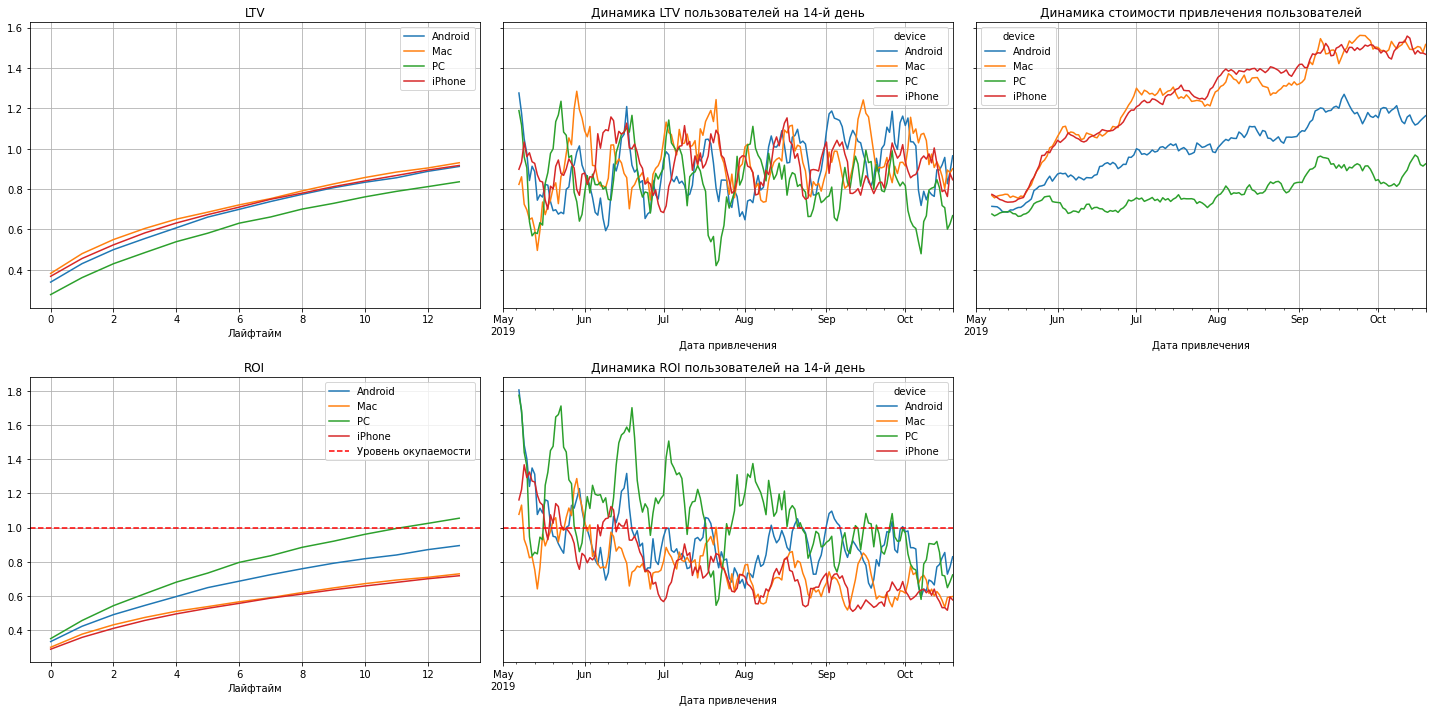

In [40]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    paid_profiles, orders, observation_date, horizon_days, dimensions=['device'])
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Видим, что LTV пользователей стандартно растет вверх для всех платфором по дням лайфтайма. Однако динамика по конечному 14му дню уже разнится, особенно у пользователей с PC и MAC. Как мы выяснили раньше: стоимость привлечения растет на протяжении всего периода - растет на каждой платформе. Соответственно, к концу периода снижается и ROI (даже у пользователей с PC, которые в среднем превышают уровень окупаемости к концу двухнедельного лайфтайма).

<a id='Окупаемость-по-странам'></a>
Проанализируем окупаемость рекламы с разбивкой по странам:

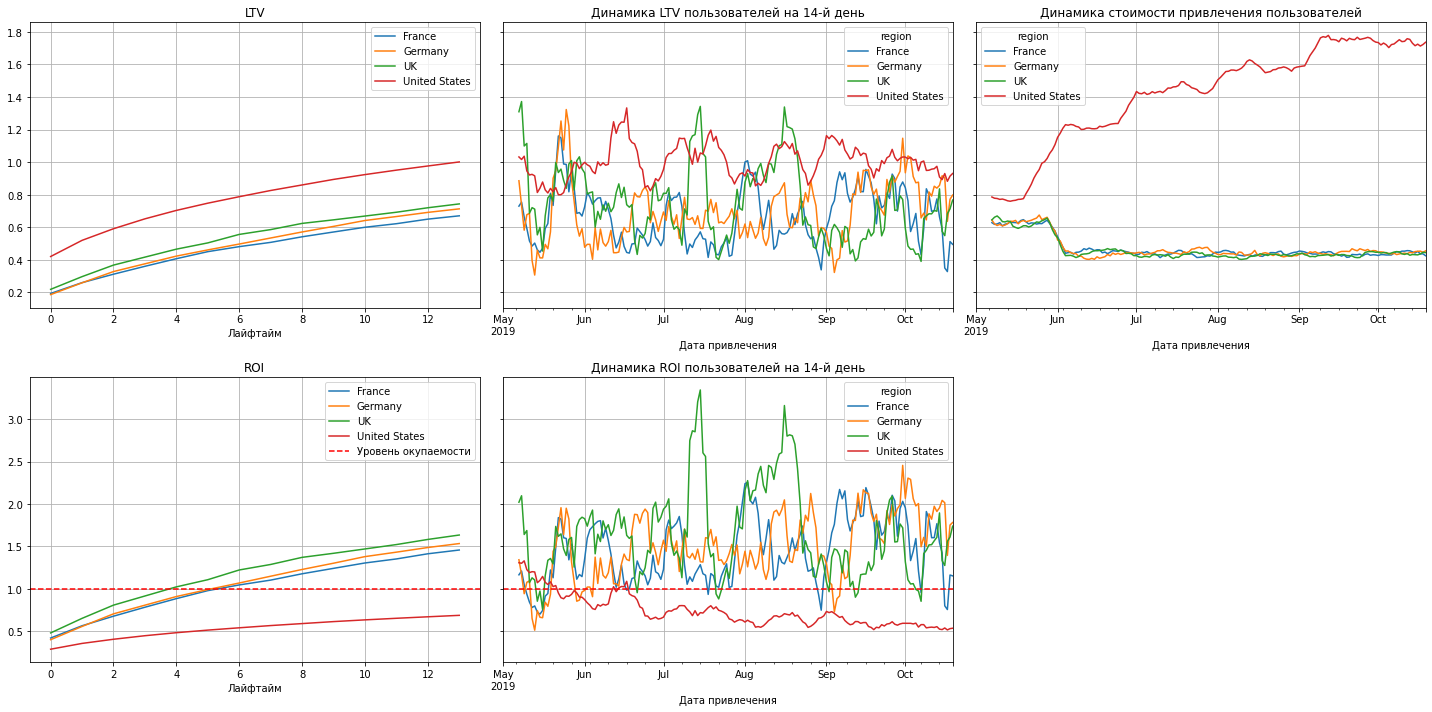

In [41]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    paid_profiles, orders, observation_date, horizon_days, dimensions=['region'])
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

При подобной разбивке сразу замечаем, что LTV и CAC у пользователей из США значительно выше, чем у пользователей из других стран. На отдельных участках графика динамики САС стоимость привлечения пользователей из США выше в несколько раз, в связи с чем окупаемость таких пользователей достигает лишь 60-70%, в отличие от пользователей из других стран. 

<a id='Окупаемость-по-каналам'></a>
Проанализируем окупаемость рекламы с разбивкой по рекламным каналам:

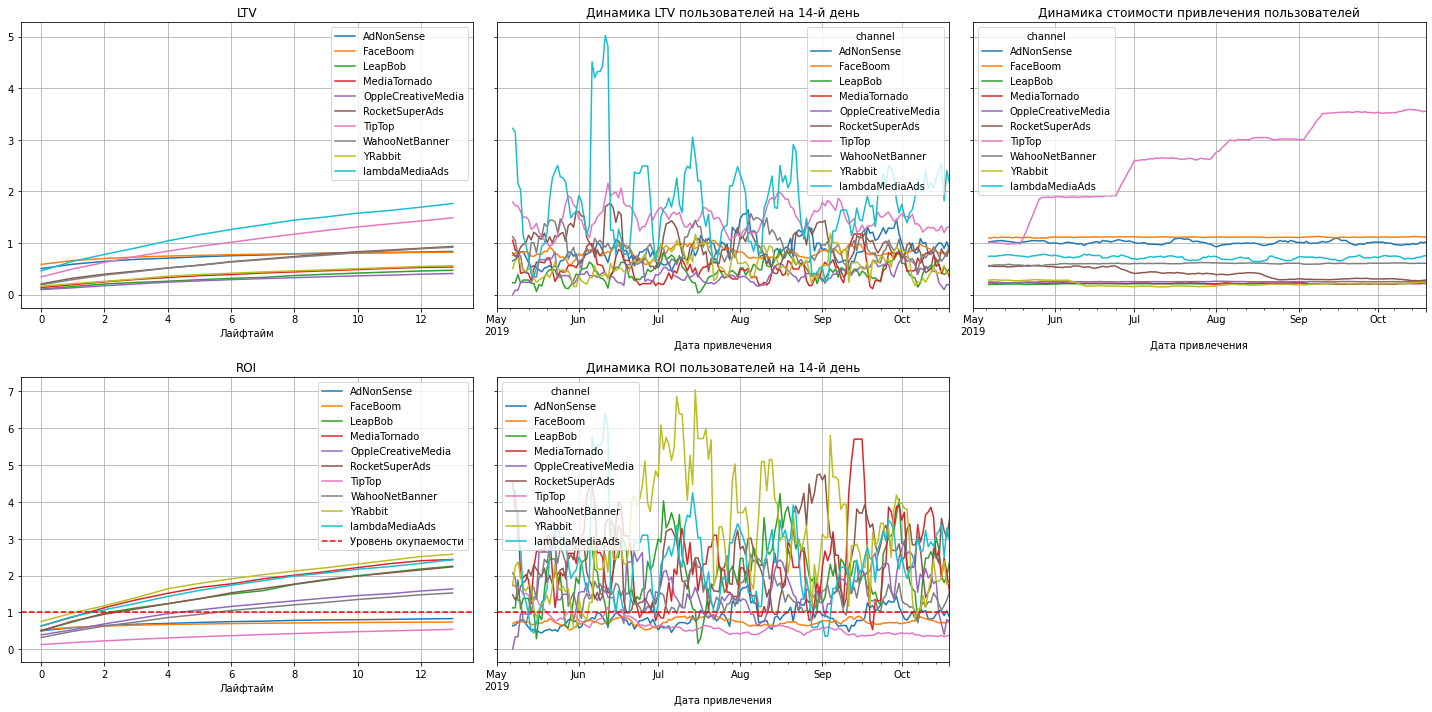

In [42]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    paid_profiles, orders, observation_date, horizon_days, dimensions=['channel'])
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

В среднем все каналы к концу двухнедельного лайфтайма окупаются, кроме 3х самых крупных по привлечению: TipTop, FaceBoom, AdNonSense. Кроме того, именно TipTop заставляет общий график динамики CAC расти вверх, так как другие каналы идут ровно. Можно отметить, что общая динамика TipTop схожа с графиками по США - скорее всего, канал связан именно с американской частью пользователей. 

<a id='Ответ-на-вопросы'></a>
Мы собрали необходимые данные и теперь можем ответить на ключевые вопросы исследования:

Окупается ли реклама, направленная на привлечение пользователей в целом?

Реклама не окупается: общий ROI достигает 80% за 14-днейвный лайфтайм пользователей. 

Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

Посредством анализа было выявлено, что:

* Пользователи любых устройств, кроме PC, не окупаются, однако пользователи с iPhone и Mac имеют наименьший ROI;
* Пользователи из США составляют основную часть клиентов сервиса, ROI которых в районе 60-70% из-за крайне высокой стоимости привлечения, пользователи остальных стран являются выгодными для нас;
* Пользователи 3х крупнейших каналов по привлечению не окупаются для нас - TipTop, FaceBoom, AdNonSense. У пользователей, привлеченных через TipTop высокий LTV, но и самая высокая стоимость привлечения, у пользователей из двух других каналов САС не такой высокий, однако LTV значительно уступает пользователям из TipTop.

Чем могут быть вызваны проблемы окупаемости?

В основном проблемы связаны с банальной невыгодностью основных каналов привлечения: TipTop, FaceBoom, AdNonSense, пользователи из которых стоят нам дороже, чем тратят. 

**Вывод:**

* Выявлено общее падение окупаемости пользователей за период исследования со 140% до 60%; 
* Динамика конверсии сопровождается скачками в диапазоне от 6,7% до 9,8%; 
* Динамика удержания платящих пользователей лучше, чем неплатящих, что является нормой;
* По устройствам окупаются только пользователи с PC, однако сложно сказать, что устройство имеет какую-либо значительную роль в этом;
* По странам окупаются все, кроме пользователей из США;
* По каналам окупаются все, кроме пользователей из 3х крупнейших: TipTop, FaceBoom, AdNonSense.

Общее падение окупаемости прямо коррелирует с повышением САС пользователей привлеченных по каналу TipTop, что доказывает невыгодность сотрудничества, аналогично с FaceBoom и AdNonSense, из которых привлекаются пользователи с низким LTV, что вместе с САС выше среднего также занижает окупаемость. 

Необходимо сотрудничать и размещать рекламу на каналах, подобных LambdaMediaAds и YRabbit, которые привлекают не так много пользователей, но значительно выше по качеству.

[Вернуться к содержанию](#Содержание)

<a id="Общий-вывод"></a>
## Общий вывод

За период с 01.05.2019 по 27.10.2019 было исследовано:

**Данные:**

* США является лидером среди всех стран по количеству пользователей (100002) и конвертации в платных пользователей (7%). Страны Европы значительно уступают по этим показателям.

* По устройствам явного лидера выявить сложнее: iPhone превосходит другие устройства по общему количеству платящих пользователей - 3382, по конвертации на первом месте Mac с 6,4%, однако, iPhone по этому показателю на втором месте с 6,2%.

* Самое большое количество платящих пользователей было привлечено через FaceBoom — 3557 пользователей, это 12.2% платящих из общего числа привлеченных по этому каналу, это лучшие показатели конвертации среди неорганических каналов.

**Маркетинг:**

* Общая сумма расходов на меркетинг за период с 1 мая по 27 октября 2019 года составила 105497.3;

* В основном, средства на маркетинг расходуются на привлечение пользователей по каналам TipTop и FaceBoom (82%), на WahooNetBanner и AdNonSense тратится среднее количество средств относительно всех каналов (8,5%), на остальные - меньше медианы;

* За взятый период только TipTop и FaceBoom показывают динамику изменений по тратам на них, остальные каналы идут в основном ровно;

* Самый дорогой канал для привлечения - TipTop (2,8 за нового пользователя), самый дешевый, не считая organic - LeapBob (0,2 за нового пользователя).

**Оценка окупаемости:**

* Выявлено общее падение окупаемости пользователей за период исследования со 140% до 60%;
* Динамика конверсии сопровождается скачками в диапазоне от 6,7% до 9,8%;
* Динамика удержания платящих пользователей лучше, чем неплатящих, что является нормой;
* По устройствам окупаются только пользователи с PC(~105%), однако сложно сказать, что устройство имеет какую-либо значительную роль в этом;
* По странам окупаются все, кроме пользователей из США(60-70%);
* По каналам окупаются все, кроме пользователей из 3х крупнейших: TipTop(60%), FaceBoom(80%), AdNonSense(90%).

**Причины неокупаемости:**

Общее падение окупаемости за взятый период прямо коррелирует с повышением САС пользователей, привлеченных по каналу TipTop, что намекает на взаимосвязь событий и доказывает невыгодность такого сотрудничества, аналогично с FaceBoom и AdNonSense, из которых привлекаются пользователи с низким LTV, что вместе с САС выше среднего также занижает окупаемость. Это 3 самых крупных канала привлечения нашего сервиса, коэффициент ROI которых ниже 1.0. 

Таким образом, основная причина неокупаемости - это направление большей части рекламного бюджета (86% относительно трат на все каналы привлечения) на сотрудничество с невыгодными каналами. 

**Рекомендация:**

1. Исходя из предшествующего анализа, пересмотреть потоки бюджета на маркетинг:
 * рассмотреть возможность отказа от размещения рекламы на невыгодных для нас каналах: FaceBoom, AdNonSense и TipTop (пользователи, привлеченные по этому каналу имеют высокий LTV, поэтому есть смысл договориться о снижении стоимости/САС);
 * искать новые варианты/расширять действующие соглашения по размещению рекламы на каналах, подобных LambdaMediaAds и YRabbit, которые на текущий момент привлекают не так много пользователей, но высоки по качеству.
2. Обратить внимание на "органично" привлеченных пользователей, которые составляют численно самую большую группу пользователей (56439), но доля плательщиков среди них всего 2% - провести мероприятия по повышению уровня конвертации этой группы. 

[Вернуться к содержанию](#Содержание)